### Description (ENG)

**Task:**

1) Analyze the test between groups 0 and 3 using the linearized likes metric. Is the difference visible? Has 𝑝−𝑣𝑎𝑙𝑢𝑒 become less compared to the usual CTR?
2) Analyze the test between groups 1 and 2 using the linearized likes metric. Is the difference visible? Has 𝑝−𝑣𝑎𝑙𝑢𝑒 become less compared to the normal CTR?

We take data in the same range in which the AB-test was carried out: from 2023-08-29 to 2023-09-04 inclusive

### Description (RUS)

**Задание:**

1) Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?
2) Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?

Данные берём в том же диапазоне, в котором проводился АБ-тест: с 2023-08-29 по 2023-09-04 включительно

### Algorithm of actions:

1) We calculate the total CTR in the control group: 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙 = 𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠) / 𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
2) We calculate the user metric in both groups 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠 = 𝑙𝑖𝑘𝑒𝑠 − 𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
3) Then, using a t-test, we compare the differences in groups according to the metric 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [2]:
import swifter 
from scipy import stats

import pandahouse 

In [3]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230920'} 

In [4]:
q = """
SELECT exp_group, user_id, sum(action = 'like') AS likes, sum(action = 'view') AS views, likes/views AS ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-08-29' AND toDate(time) <= '2023-09-04' AND exp_group IN (0, 1, 2, 3)
GROUP BY exp_group, user_id
"""

In [5]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [6]:
df.head(3)

,exp_group,user_id,likes,views,ctr
0,1,18392,7,32,0.218750
1,3,115383,12,44,0.272727
2,3,123580,2,11,0.181818


In [7]:
group_0 = df[df.exp_group == 0].copy()
group_1 = df[df.exp_group == 1].copy()
group_2 = df[df.exp_group == 2].copy()
group_3 = df[df.exp_group == 3].copy()

In [8]:
group_0['ctr_control'] = group_0.likes.sum() / group_0.views.sum() # контрольная группа
group_3['ctr_control'] = group_0.likes.sum() / group_0.views.sum()

group_1['ctr_control'] = group_1.likes.sum() / group_1.views.sum() # контрольная группа
group_2['ctr_control'] = group_1.likes.sum() / group_1.views.sum() 

In [9]:
group_0['linearized_likes'] = group_0.likes - group_0.ctr_control*group_0.views
group_3['linearized_likes'] = group_3.likes - group_3.ctr_control*group_3.views

group_1['linearized_likes'] = group_1.likes - group_1.ctr_control*group_1.views
group_2['linearized_likes'] = group_2.likes - group_2.ctr_control*group_2.views

### Difference between group 0 and 3 

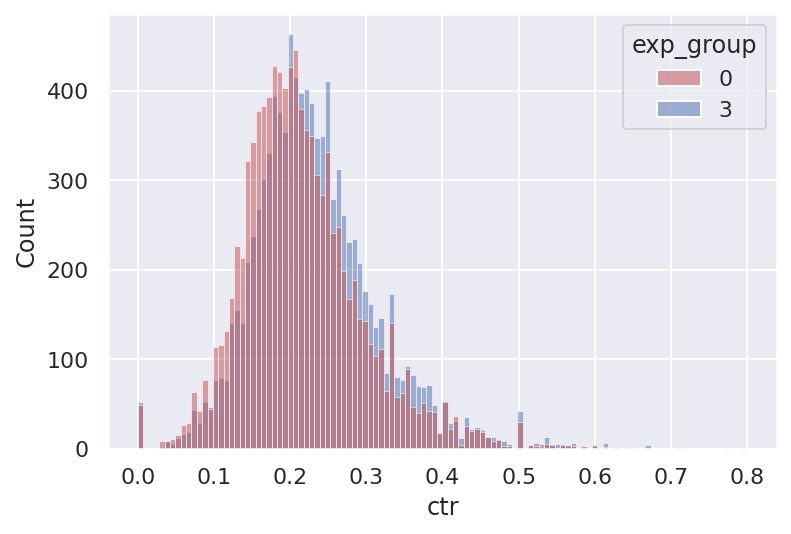

In [10]:
# Let's look visually at the CTR distributions within the two groups
sns.set(rc={'figure.figsize':(8,4)})

groups = sns.histplot(data = pd.concat([group_0, group_3]), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

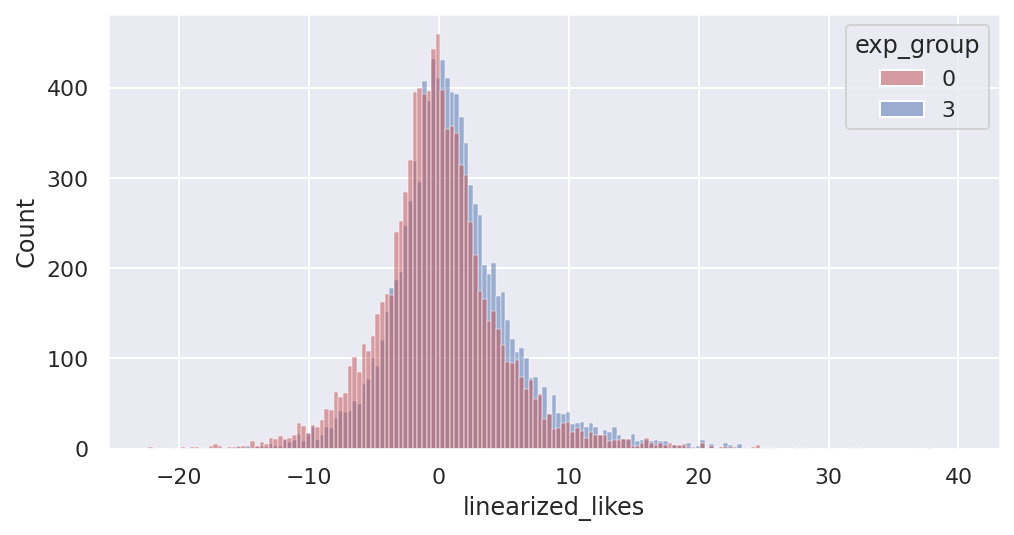

In [11]:
# Let's look visually at the distribution of linearized likes within two groups
sns.set(rc={'figure.figsize':(8,4)})

groups = sns.histplot(data = pd.concat([group_0, group_3]), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [12]:
# t-test using CTR as a metric
stats.ttest_ind(group_0.ctr,
                group_3.ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755823, pvalue=6.216047483057877e-44)

In [13]:
# t-test using linearized likes as a metric
stats.ttest_ind(group_0.linearized_likes,
                group_3.linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-16.18623003293285, pvalue=1.4918137745324434e-58)

In [14]:
# Mann-Whitney test using CTR as a metric
stats.mannwhitneyu(group_0.ctr, 
                   group_3.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43165459.5, pvalue=8.916679404235955e-57)

In [15]:
# Mann-Whitney test using linearized likes as a metric
stats.mannwhitneyu(group_0.linearized_likes, 
                   group_3.linearized_likes,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=42681950.0, pvalue=2.504376811309453e-65)

**Conclusion:** thus, the difference can be seen - according to the results of both tests, **p-value** **dropped** by many orders of magnitude when using the linearized likes metric compared to the usual CTR.

### Difference between group 1 and 2

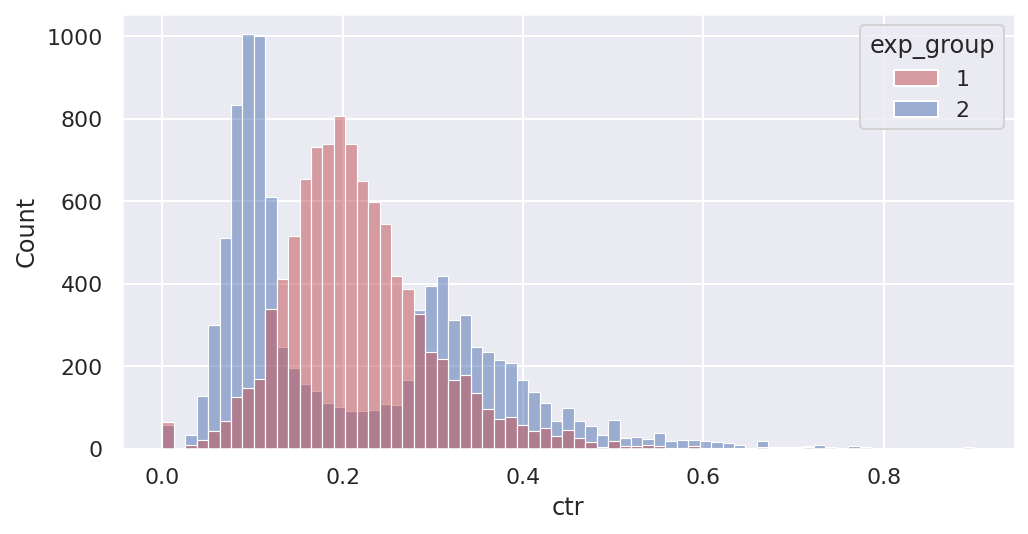

In [16]:
# Let's look visually at the CTR distributions within the two groups
sns.set(rc={'figure.figsize':(8,4)})

groups = sns.histplot(data = pd.concat([group_1, group_2]), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

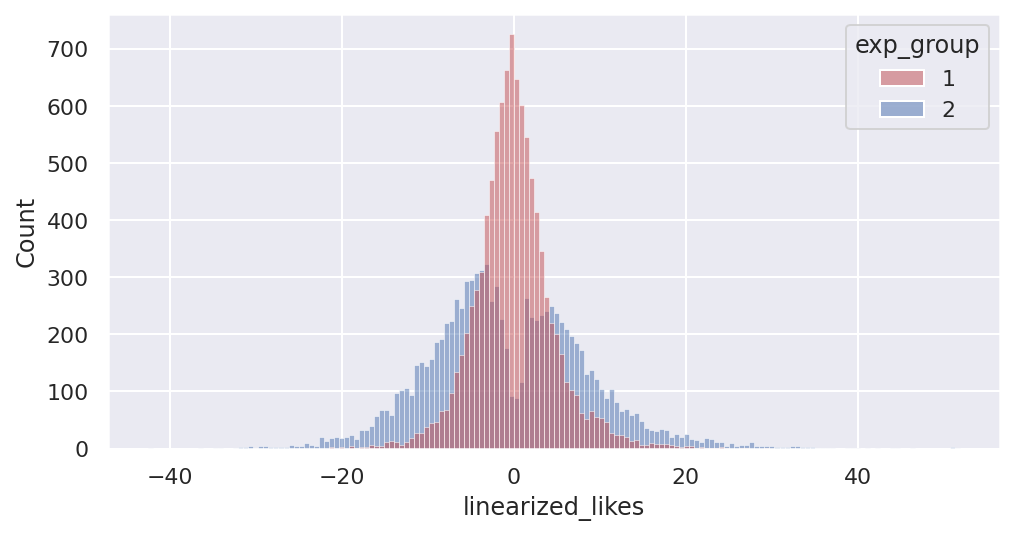

In [17]:
# Let's look visually at the distribution of linearized likes within two groups
sns.set(rc={'figure.figsize':(8,4)})

groups = sns.histplot(data = pd.concat([group_1, group_2]), 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [18]:
# t-test using CTR as a metric
stats.ttest_ind(group_1.ctr,
                group_2.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.40514919131127564, pvalue=0.685373331140751)

In [19]:
# t-test using linearized likes as a metric
stats.ttest_ind(group_1.linearized_likes,
                group_2.linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.936377101934478, pvalue=2.9805064038668383e-09)

**Conclusion**: the **p-value has become smaller** - now the null hypothesis is rejected at any standard significance level $\Rightarrow$ t-test revealed differences between groups for linearized likes, which was not observed for CTR due to the features of CTR distributions in the second group.